# Multi-Tissue Constrained Spherical Deconvolution

Multi-Tissue CSD (MT-CSD), or what *Jeurissen et al. (2014)* refers to as Multi-Shell Multi-Tissue CSD (MSMT-CSD), is in extension of regular CSD algorithm. In MT-CSD, Aside from the standard white matter convolution kernel, also a CSF and grey matter kernel are estimated from the data, and fitted simultaneously fitted for better FOD estimation.

$$
\begin{equation}
 E_{\textrm{MT-CSD}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{CSF}}+ \underbrace{f_{\textrm{GM}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{Grey Matter}} + \underbrace{f_r\left[\overbrace{\operatorname{FOD}(\operatorname{SH}|l_{\textrm{max}})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{E_{\textrm{WM}}(\cdot)}^{\textrm{Anisotropic Response}}\right]}_{\textrm{White Matter}}
\end{equation}
$$

The original algorithm uses registered T1 image segmentations of white/grey matter and CSF to obtain these separate kernels, but this has shown to be a difficult and expensive process. Instead, we implement unsupervised approach by *Dhollander et al. (2016)* that directly estimates the three tissue kernels from the dMRI data itself.

Once the kernels are estimated, they can be used exactly as any other Dmipy compartment model. This means they can be used in any modeling framework together with other models as usual.

As you will see, MT-CSD results in very well-defined FOD profiles and hardly any noisy voxels around CSF or Grey matter areas.

## Using Dmipy to set up the MT-CSD Model¶

Setting up the MT-CSD model in Dmipy is very easy. The only thing that needs to be done is to generate the WM/GM/CSF tissue response models from the data using the dhollander16 algorithm. Then, the rest of the modeling can be done as usual.

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

/home/rutger/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [2]:
scheme_hcp.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  
2           |90        |2000            |79                       |10.6       |43.1      |N/A  
3           |90        |3000            |97                       |10.6       |43.1      |N/A  


In [56]:
scheme_01_shell, data_01_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 1], data_hcp)
scheme_02_shell, data_02_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 2], data_hcp)
scheme_03_shell, data_03_shell = scheme_hcp.return_pruned_acquisition_scheme([0, 3], data_hcp)
schemes = [scheme_01_shell, scheme_02_shell, scheme_03_shell, scheme_hcp]
data = [data_01_shell, data_02_shell, data_03_shell, data_hcp]

In [42]:
scheme_01_shell.print_acquisition_info

Acquisition scheme summary

total number of measurements: 108
number of b0 measurements: 18
number of DWI shells: 1

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  


In [43]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
tissue_responses = []
selection_maps = []
for scheme, data in zip(schemes, data):
    wm, gm, csf, selection_map = three_tissue_response_dhollander16(
        scheme, data, wm_algorithm='tournier07',
        wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
    tissue_responses.append([wm, gm, csf])
    selection_maps.append(selection_map)

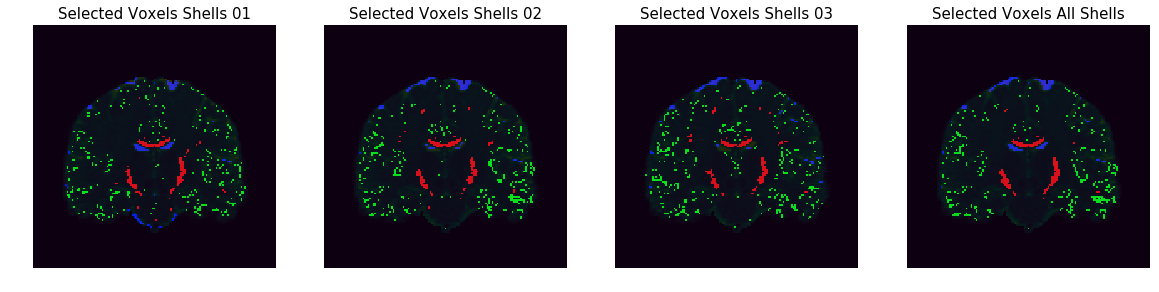

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(figsize=[20, 5], ncols=4)
axs = axs.ravel()

for ax, selection_map, txt in zip(axs, selection_maps, ['Shells 01', 'Shells 02', 'Shells 03', 'All Shells']):
    ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
    ax.imshow(selection_map.squeeze().transpose((1, 0, 2)), origin=True, alpha=0.8)
    ax.set_axis_off()
    ax.set_title('Selected Voxels {}'.format(txt), fontsize=15);

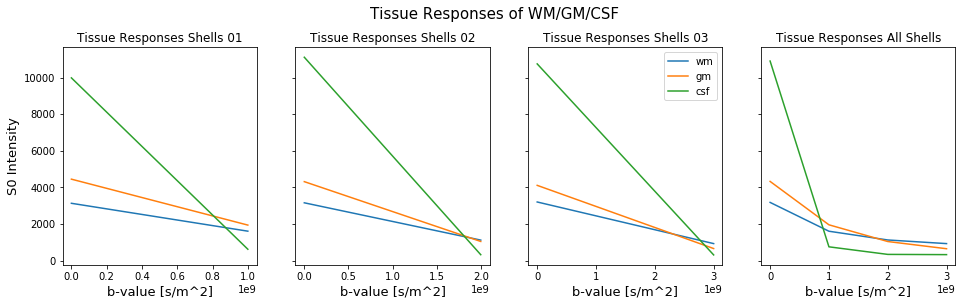

In [55]:
fig, axs = plt.subplots(figsize=[16, 4], ncols=4, sharey=True)
fig.suptitle('Tissue Responses of WM/GM/CSF', fontsize=15, y=1.02)
axs = axs.ravel()
axs[0].set_ylabel('S0 Intensity', fontsize=13)
for ax, scheme, tissue_response, txt in zip(
        axs, schemes, tissue_responses, ['Shells 01', 'Shells 02', 'Shells 03', 'All Shells']):
    for response, name in zip(tissue_response, ['wm', 'gm', 'csf']):
        ax.plot(scheme.shell_bvalues, response.tissue_response(), label=name)
    ax.set_xlabel('b-value [s/m^2]', fontsize=13)
    ax.set_title('Tissue Responses {}'.format(txt))
axs[2].legend()

In [38]:
import time
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
def single_shell_three_tissue_csd(acquisition_scheme, data, tissue_responses, it_max=4,
                                  csd_fit_verbose=False, dhollander_verbose=False):
    """
    Implementation of Single-Shell (1 shell + b0) three-tissue CSD [1]_.
    
    Parameters
    ----------
    tissue_responses: list of Dmipy tissue response models,
        assumed to be in the same order as they are generated using the dhollander16 tissue
        response estimation, i.e. [wm, gm, csf].
    acquisition_scheme: Dmipy acquisition scheme,
        single shell (or whatever-shell) acquisition scheme.
    data: ND-array of shape (Nx...., NDWI),
        the fitted that is to be fitted.
    
    References
    ----------
    .. [1] DHollander 16 blabla
    """

    fit_args = {
        'acquisition_scheme': acquisition_scheme,
        'data': data,
        'mask': data[..., 0]>0,
        'fit_S0_response': True,
        'verbose': csd_fit_verbose}

    csd_fits = []
    for it in range(it_max):
        start = time.time()
        mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
        if it == 0:
            mt_csd_mod.set_fixed_parameter('partial_volume_0', np.zeros(data.shape[:-1]))
        else:
            mt_csd_mod.set_fixed_parameter('partial_volume_0',
                                           mt_csd_fit.fitted_parameters['partial_volume_0'])
        mt_csd_fit = mt_csd_mod.fit(**fit_args)
        csd_fits.append(mt_csd_fit)

        mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_responses)
        mt_csd_mod.set_fixed_parameter('partial_volume_2',
                                       mt_csd_fit.fitted_parameters['partial_volume_2'])
        mt_csd_fit = mt_csd_mod.fit(**fit_args)
        csd_fits.append(mt_csd_fit)
        computation_time = time.time() - start
        if dhollander_verbose:
            print('finish it {} of {} in {} seconds'.format(it + 1, it_max, int(computation_time)))
    return csd_fits

In [29]:
import numpy as np
def generate_synthetic_multi_tissue_data(acquisition_scheme, tissue_responses, fractions=None):
    if fractions is None:
        fractions = np.random.rand(len(tissue_responses))
        fractions /= fractions.sum()
    data = 0.
    for vf, response in zip(fractions, tissue_responses):
        data += vf * response.S0_response * response(acquisition_scheme, mu=[0., 0.])
    data =  np.array([data])
    return fractions, data

def get_fractions(csd_fits):
    partial_volumes = []
    for fit in csd_fits:
        partial_volumes.append([
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[0]],
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[1]],
            fit.fitted_and_linked_parameters[fit.model.partial_volume_names[2]]])
    fractions = np.array(partial_volumes).squeeze().T
    return fractions

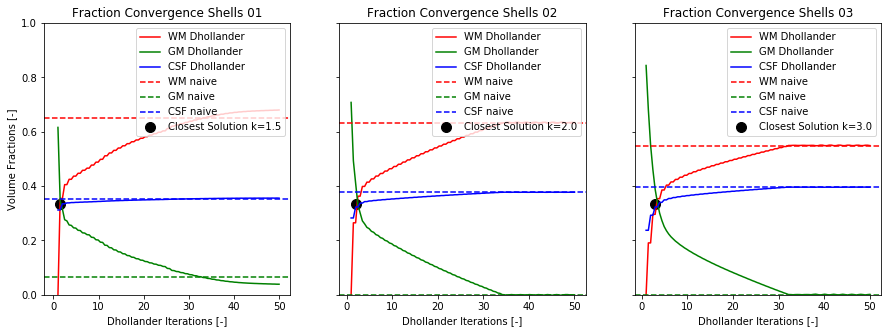

In [30]:
gt_fractions = [1/3., 1/3., 1/3.]
it_max = 50
its = np.linspace(1, 50, 100)

fig, axs = plt.subplots(figsize=[15, 5], ncols=3, sharey=True)
axs = axs.ravel()

axs[0].set_ylabel('Volume Fractions [-]')
axs[0].set_ylim(0, 1)
for ax, scheme, tissue_response, txt in zip(axs, schemes, tissue_responses, ['Shells 01', 'Shells 02', 'Shells 03']):
    _, data_test = generate_synthetic_multi_tissue_data(scheme, tissue_response, gt_fractions)
    fits = single_shell_three_tissue_csd(scheme, data_test, tissue_response, it_max=it_max)
    estimated_fractions = get_fractions(fits)
    closest_index = (np.argmin(np.sum((estimated_fractions - 1/3.) ** 2, axis=0)) + 1) / 2.
    
    mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(tissue_response)
    naive_fit = mt_csd_mod.fit(scheme, data_test, fit_S0_response=True, verbose=False)
    
    ax.plot(its, estimated_fractions[0], c='r', label='WM Dhollander')
    ax.plot(its, estimated_fractions[1], c='g', label='GM Dhollander')
    ax.plot(its, estimated_fractions[2], c='b', label='CSF Dhollander')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_0'], c='r', ls='--', label='WM naive')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_1'], c='g', ls='--', label='GM naive')
    ax.axhline(naive_fit.fitted_parameters['partial_volume_2'], c='b', ls='--', label='CSF naive')
    ax.scatter(closest_index, 1/3., s=100, c='k', label='Closest Solution k={}'.format(closest_index))
    ax.set_xlabel('Dhollander Iterations [-]')
    ax.set_title('Fraction Convergence {}'.format(txt))
    ax.legend(loc='upper right')

In [31]:
closest_indices = []
vfs_gt = []
absolute_difference = []
index = 2
for iteration in range(50):
    vf_gt, data_test = generate_synthetic_multi_tissue_data(schemes[index], tissue_responses[index])
    fits = single_shell_three_tissue_csd(schemes[index], data_test, tissue_responses[index], it_max=10)
    estimated_fractions = get_fractions(fits)
    absolute_difference.append(min(np.sum(abs(estimated_fractions.T - vf_gt), axis=1)))
    closest_indices.append((np.argmin(np.sum(abs(estimated_fractions.T - vf_gt), axis=1)) + 1) / 2.)
    vfs_gt.append(vf_gt)

(array([ 1.,  2.,  1.,  1., 43.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
         3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
         5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
         8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ]),
 <a list of 19 Patch objects>)

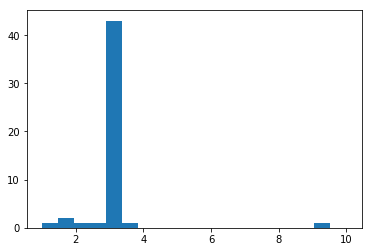

In [32]:
plt.hist(closest_indices, bins=np.linspace(1, 10, 20))

In [33]:
vfs_gt[np.argmax(closest_indices)]

array([0.67805177, 0.00374675, 0.31820148])

In [34]:
absolute_difference[np.argmax(closest_indices)]

0.04867541936686328

In [35]:
vfs_gt[np.argmin(closest_indices)]

array([0.48777457, 0.50818615, 0.00403928])

In [62]:
full_fits = []
for scheme, data, tissue_response in zip(
        schemes[:-1], data[:-1], tissue_responses[:-1]):
    print('bla')
    full_fits.append(single_shell_three_tissue_csd(
        scheme, data, tissue_response, it_max=4,
        csd_fit_verbose=False, dhollander_verbose=True))

bla
finish it 1 of 4 in 223 seconds
finish it 2 of 4 in 231 seconds
finish it 3 of 4 in 219 seconds
finish it 4 of 4 in 224 seconds
bla
finish it 1 of 4 in 217 seconds
finish it 2 of 4 in 216 seconds
finish it 3 of 4 in 248 seconds
finish it 4 of 4 in 240 seconds
bla
finish it 1 of 4 in 252 seconds
finish it 2 of 4 in 234 seconds
finish it 3 of 4 in 239 seconds
finish it 4 of 4 in 260 seconds


In [48]:
mtcsd_mod_3shell = (
    MultiCompartmentSphericalHarmonicsModel(tissue_responses[-1]))
mtcsd_fit_3shell = mtcsd_mod_3shell.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, fit_S0_response=True)

Setup CVXPY FOD optimizer in 0.0121400356293 seconds
Using parallel processing with 8 workers.
Fitting of 8181 voxels complete in 139.693479061 seconds.
Average of 0.0170753549763 seconds per voxel.


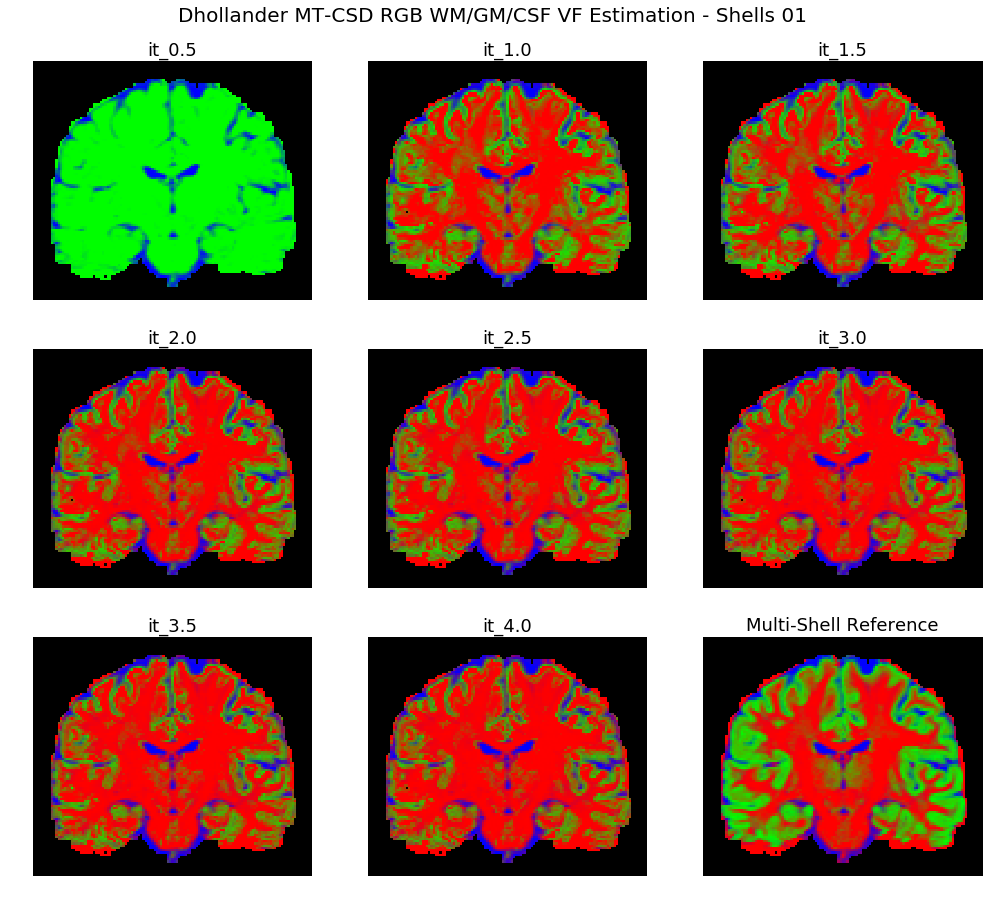

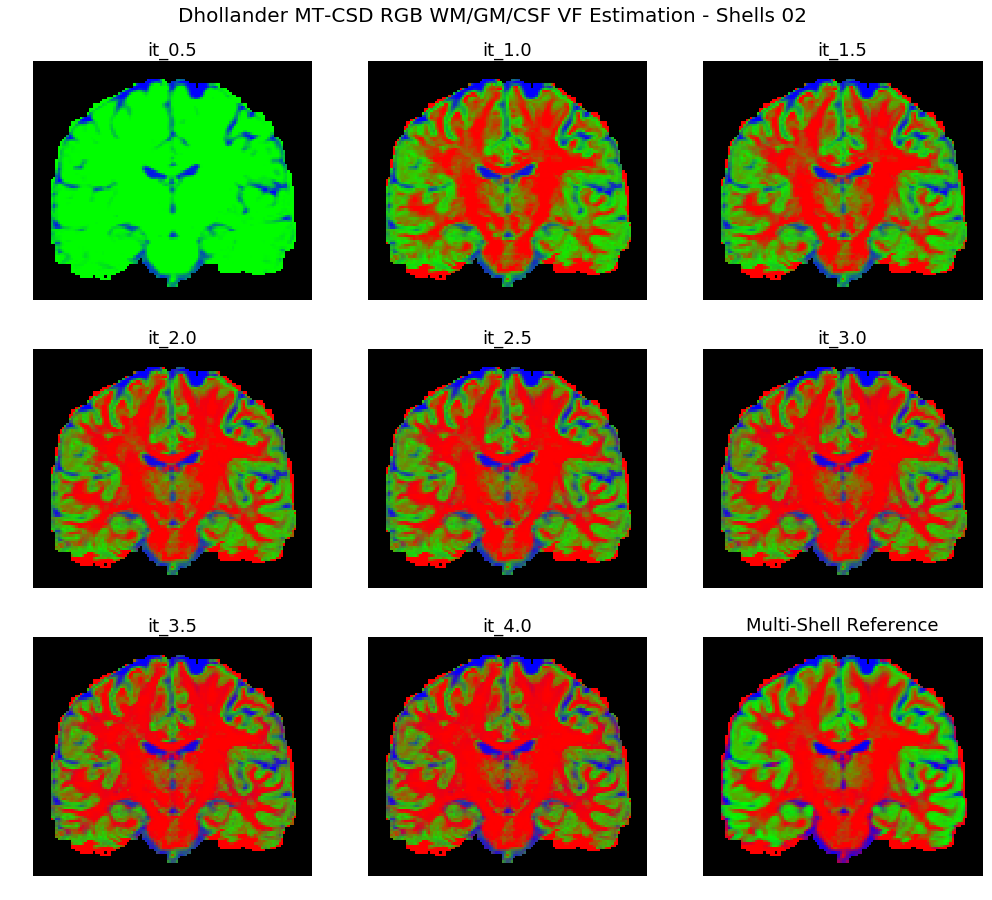

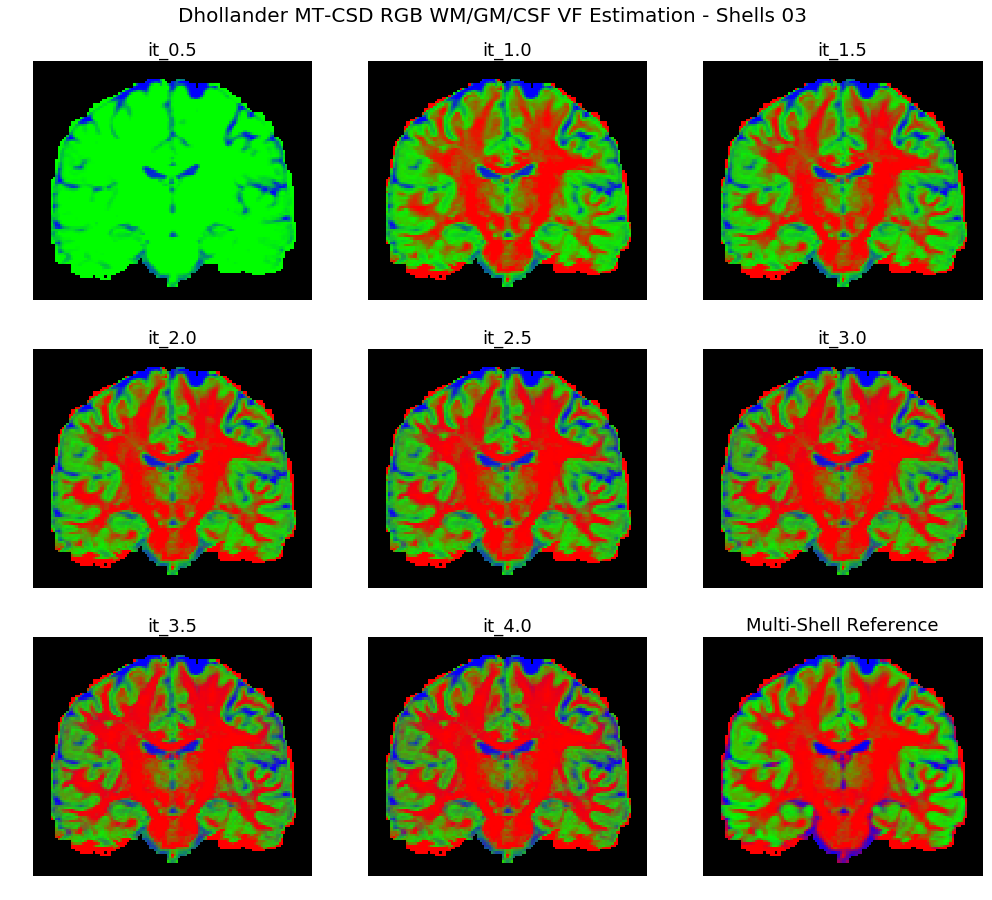

In [74]:
import numpy as np
vfs_all = []
for full_fit, title in zip(full_fits, ['Shells 01', 'Shells 02', 'Shells 03']):
    fig, axs = plt.subplots(3, 3, figsize=[17, 15])
    axs = axs.ravel()
    fig.suptitle('Dhollander MT-CSD RGB WM/GM/CSF VF Estimation - {}'.format(title), 
                 fontsize=20, y=0.93)
    for i, fit in enumerate(full_fit):
        vfs = []
        names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
        for name in names:
            vfs.append(fit.fitted_and_linked_parameters[name])
        vfs = np.clip(np.transpose(np.array(vfs), (3, 2, 1, 0)), 0, np.inf)
        
        vfs_sum = np.sum(vfs, axis=-1)
        vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
        vfs_im = np.squeeze(vfs)

        axs[i].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
        axs[i].axis('off');
        axs[i].set_title("it_{}".format((i + 1.) / 2.), fontsize=18)
    vfs_all.append(vfs)
    
    vfs = []
    names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
    for name in names:
        vfs.append(mtcsd_fit_3shell.fitted_and_linked_parameters[name])
    vfs = np.transpose(np.array(vfs), (3, 2, 1, 0))
    vfs_sum = np.sum(vfs, axis=-1)
    vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
    vfs_im = np.squeeze(np.clip(vfs, 0, 1))

    axs[-1].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[-1].axis('off');
    axs[-1].set_title("Multi-Shell Reference", fontsize=18)
vfs_all.append(vfs)

### Visualizing Fiber Orientation Distributions

As before, we can visualize the FOD estimated using MT-CSD. We do both with and without including the S0 response.

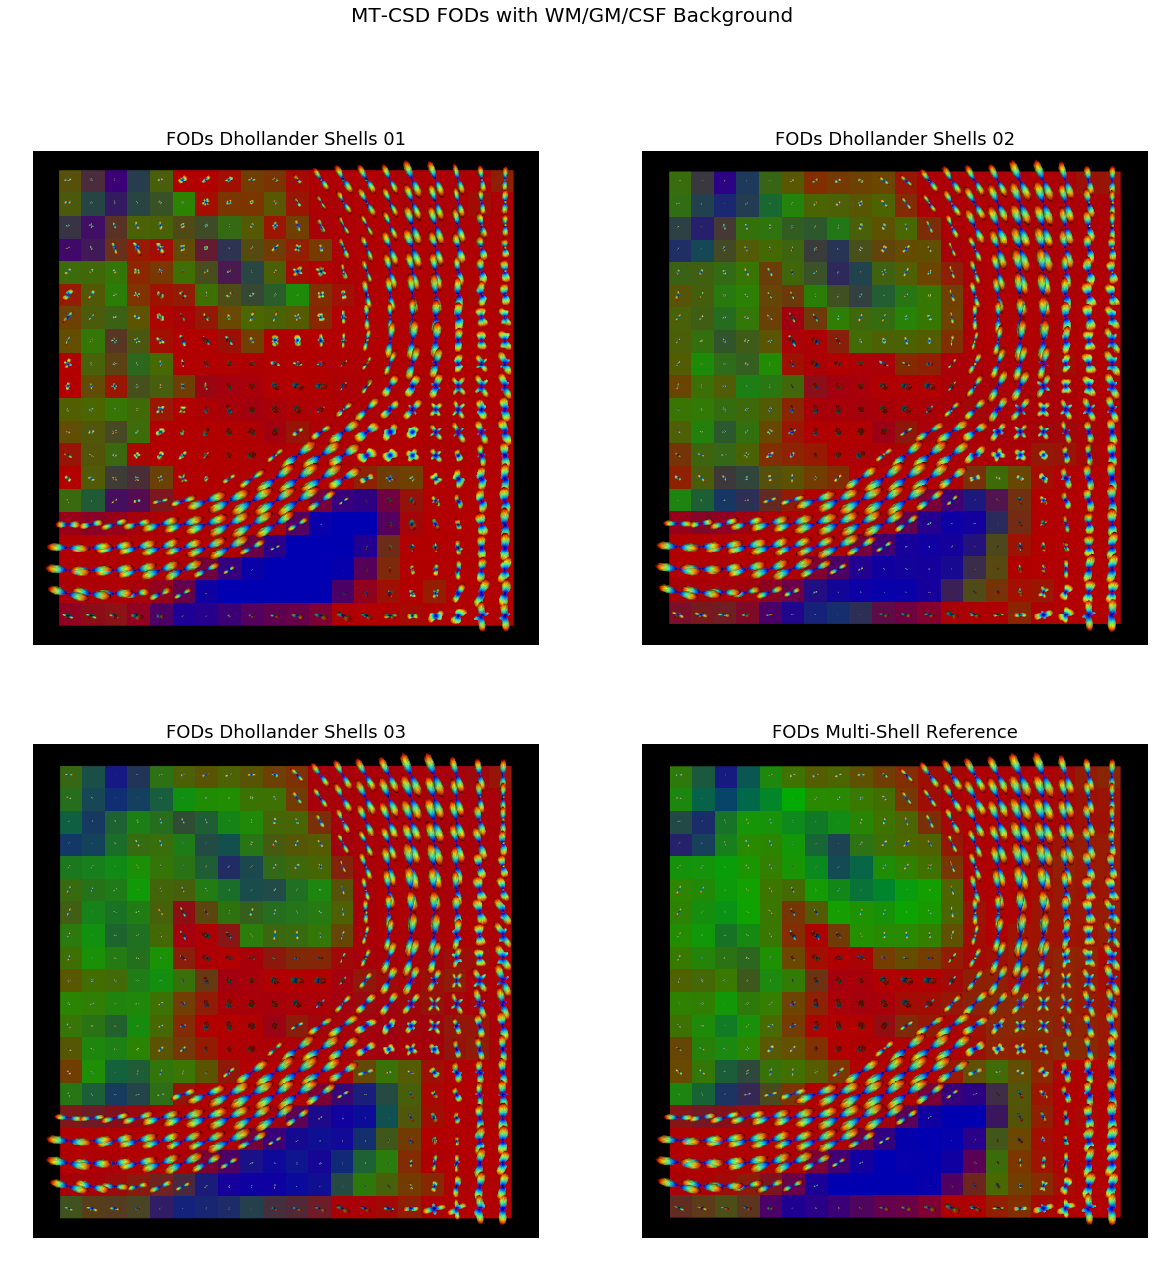

In [76]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
from dipy.viz import fvtk
import numpy as np
import matplotlib.image as mpimg

sphere = get_sphere(name='symmetric724')
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

txts = ['FODs Dhollander Shells 01',
        'FODs Dhollander Shells 02', 
        'FODs Dhollander Shells 03', 
        'FODs Multi-Shell Reference']

fig, axs = plt.subplots(2, 2, figsize=[20, 20])
axs = axs.ravel()
fig.suptitle('MT-CSD FODs with WM/GM/CSF Background', fontsize=20)

viz_fits = [full_fit[-1] for full_fit in full_fits]
viz_fits.append(mtcsd_fit_3shell)

for i, (txt, vfs, fit) in enumerate(zip(txts, vfs_all, viz_fits)):
    fods = fit.fod(sphere.vertices)

    vfs2 = np.transpose(vfs, (2, 1, 0, 3))
    ai_im = slicer(vfs2[70:90,0, 70:90, None, :],
        interpolation='nearest', affine=affine, opacity=0.7)

    ren = fvtk.ren()
    fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
    fod_spheres.RotateX(90)
    fod_spheres.RotateZ(180)
    fod_spheres.RotateY(180)
    fvtk.add(ren, fod_spheres)
    fvtk.add(ren, ai_im)
    fvtk.record(ren=ren, size=[700, 700])

    img = mpimg.imread('dipy.png')

    axs[i].imshow(img[100:-97, 100:-85])
    axs[i].set_title(txt, fontsize=18)
    axs[i].axis('off');

Looks like single-shell three-tissue CSD works better with b0 and a higher b-value shell. Shells 03 looks remarkably similar to the 3-shell (3 shell + b0) reference.

## References
- Tournier, J-Donald, Fernando Calamante, and Alan Connelly. "Robust determination of the fibre orientation distribution in diffusion MRI: non-negativity constrained super-resolved spherical deconvolution." Neuroimage 35.4 (2007): 1459-1472.
- Dhollander, T.; Raffelt, D. & Connelly, A. Unsupervised 3-tissue response function estimation from single-shell or multi-shell diffusion MR data without a co-registered T1 image. ISMRM Workshop on Breaking the Barriers of Diffusion MRI, 2016, 5
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.